In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/batman/Documents/ma221/gfloat/src')
import gfloat
print(dir(gfloat))
from gfloat.formats import *
from gfloat import decode_float
# sys.path.append('/home/batman/Documents/cs282a/proj/test_model/fastMRI')
# from fastmri import fft2c, ifft2c, rss_complex, rss
# from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc
# from fastmri.evaluate import mse, nmse, psnr, ssim

/home/batman/anaconda3/envs/fp8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['BlockFormatInfo', 'FloatClass', 'FloatValue', 'FormatInfo', 'RoundMode', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'block', 'compute_scale_amax', 'decode', 'decode_block', 'decode_float', 'decode_ndarray', 'encode', 'encode_block', 'encode_float', 'encode_ndarray', 'float_pow2str', 'float_tilde_unless_roundtrip_str', 'printing', 'quantize_block', 'round', 'round_float', 'round_ndarray', 'types']


kspace: (8, 230, 180) complex64


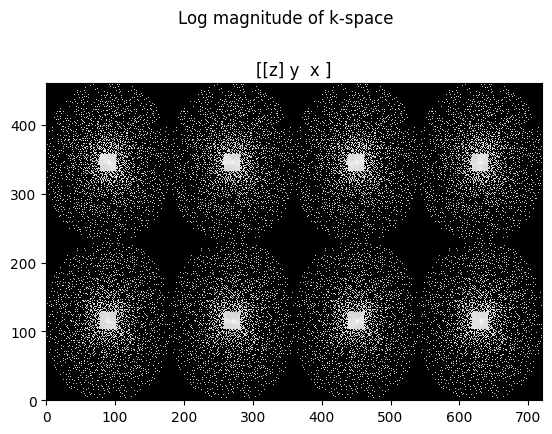

EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 147.95it/s]


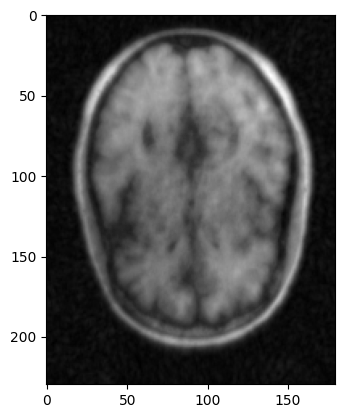

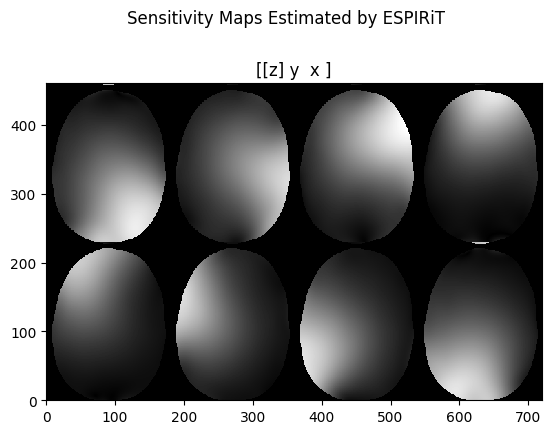

Sensitivity maps: (8, 230, 180) complex64


In [3]:
ksp_path = '/home/batman/Documents/sigpy_tutorial/sigpy-mri-tutorial/data/' # undersampled
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)
pl.ImagePlot(ksp, mode='l', z=0, title='Log magnitude of k-space')


img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

In [10]:
def to_fp8(x, format=format_info_binary32):
    fp8_real = gfloat.round_ndarray(format, x.real) #format_info_ocp_e4m3 
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(kspace, sensitivity_maps, num_iters=5, lamda=1e-2, tol=1e-6, use_fp16=False, use_fp8=False, format=format_info_binary32):
    num_coil, nrows, ncols = kspace.shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)

    W = get_weights(kspace)

    def forward_op(x):
        x_expand = np.expand_dims(x, axis=0)
        shifted_image = np.fft.fftshift(sensitivity_maps * x_expand, axes=(1, 2))
        return W**0.5 * np.fft.fft2(shifted_image, norm='ortho')

    def adjoint_op(y):
        ifft_result = np.fft.ifft2(y, norm='ortho')
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(1, 2))
        return np.sum(sensitivity_maps.conj() * shifted_ifft_result, axis=0)

    def normal_op(x):
        result = adjoint_op(forward_op(x)) + lamda * x
        if use_fp8:
            return to_fp8(result, format)  # Consider applying FP8 here sparingly
        elif use_fp16:
            return to_fp16(result, format)
        else:
            return result

    if use_fp8:
        AHy = to_fp8(adjoint_op(kspace), format)
    elif use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace)

    # Initialize variables in FP16 or FP32, no FP8 here for stability
    x = np.zeros_like(AHy, dtype=np.float16 if use_fp16 else np.complex64)
    r = AHy - normal_op(x)
    z = r.copy()
    p = z.copy()

    rz_old = np.vdot(r, z)
    resid = np.sqrt(rz_old)

    for i in range(num_iters):
        # Only cast Ap to FP8 if necessary
        if use_fp8:
            Ap = to_fp8(normal_op(p), format)
        elif use_fp16:
            Ap = to_fp16(normal_op(p))
        else:
            Ap = normal_op(p)

        pAp = np.vdot(p, Ap)
        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break

        alpha = rz_old / pAp
        x += alpha * p
        r -= alpha * Ap

        if use_fp8:
            z = to_fp8(r, format)  # Only if memory is critical
        elif use_fp16:
            z = to_fp16(r)
        else:
            z = r

        rz_new = np.vdot(r, z)
        resid = np.sqrt(rz_new)
        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = rz_new / rz_old
        if use_fp8:
            p = to_fp8(z + beta * p, format)
        elif use_fp16:
            p = to_fp16(z + beta * p)
        else:
            p = z + beta * p

        rz_old = rz_new
        if i % 10 == 0:
            print("Iteration:", i) 
    return x


# recon_img = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2)
# recon_img_fp16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_binary16) 
# recon_img_bf16 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_bfloat16) 
recon_img_fp8_e5m2_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e5m2)
recon_img_fp8_e5m2_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e5m2)  

recon_img_fp8_e4m3_0p01 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp8=True, format=format_info_ocp_e4m3)
recon_img_fp8_e4m3_0p1 = conjugate_sense_reconstruction(ksp, mps, lamda=1e-1, use_fp8=True, format=format_info_ocp_e4m3)

# np.save('/home/batman/Documents/ma221/recon_img', recon_img)
# np.save('/home/batman/Documents/ma221/recon_img_fp16', recon_img_fp16)
# np.save('/home/batman/Documents/ma221/recon_img_bf16', recon_img_bf16)
np.save('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p01_iter5', recon_img_fp8_e5m2_0p01)
np.save('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p01_iter5', recon_img_fp8_e4m3_0p01)
np.save('/home/batman/Documents/ma221/recon_img_fp8_e5m2_0p1_iter5', recon_img_fp8_e5m2_0p1)
np.save('/home/batman/Documents/ma221/recon_img_fp8_e4m3_0p1_iter5', recon_img_fp8_e4m3_0p1)



#recon_img_16b_input = conjugate_sense_reconstruction(ksp, mps, lamda=1e-2, use_fp16=False) 


# plt.figure(figsize=(10,10))
# plt.subplot(151)
# plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
# plt.title('FP32')
# plt.axis('off')
# plt.subplot(152)
# plt.imshow(np.abs(np.flip(recon_img_fp16)), cmap='gray')
# plt.title('FP16')
# plt.axis('off')
# plt.subplot(153)
# plt.imshow(np.abs(np.flip(recon_img_bf16)), cmap='gray')
# plt.title('BF16')
# plt.axis('off')
# plt.subplot(154)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(155)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e4m3)), cmap='gray')
# plt.title('FP8 E4M3')
# plt.axis('off')
# plt.tight_layout()

# plt.figure(figsize=(10,5))
# plt.subplot(211)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p01)), cmap='gray')
# plt.title('FP8 E5M2')
# plt.axis('off')
# plt.subplot(212)
# plt.imshow(np.abs(np.flip(recon_img_fp8_e5m2_0p1)), cmap='gray')
# #plt.title('FP8 E4M3')
# plt.axis('off')



Iteration: 0
Iteration: 0
Iteration: 0
Iteration: 0


#### make fp8 conversion

In [78]:
print(np.max(to_fp8(mps)).real)

0.875


In [26]:
test_array = np.random.rand(3, 2, 2).astype(np.float32) + 1j *  np.random.rand(3, 2, 2).astype(np.float32)
print(test_array, test_array.dtype, test_array.shape)
#format_info_p3109(5)
fp8_real = gfloat.round_ndarray(format_info_ocp_e4m3, test_array.real)
fp8_imag = gfloat.round_ndarray(format_info_ocp_e4m3, test_array.imag) 
fp8_complex = fp8_real + 1j * fp8_imag
print(fp8_complex, fp8_complex.shape)

[[[0.00642775+0.6845798j  0.7306656 +0.14888035j]
  [0.4636323 +0.07344934j 0.9461162 +0.99934876j]]

 [[0.40658563+0.40099064j 0.38258603+0.73869914j]
  [0.8341926 +0.28013715j 0.30429512+0.6124034j ]]

 [[0.60303605+0.7925738j  0.66457635+0.9918134j ]
  [0.8806115 +0.12189328j 0.15831666+0.12144274j]]] complex64 (3, 2, 2)
[[[0.00585938+0.6875j    0.75      +0.15625j  ]
  [0.46875   +0.0703125j 0.9375    +1.j       ]]

 [[0.40625   +0.40625j   0.375     +0.75j     ]
  [0.8125    +0.28125j   0.3125    +0.625j    ]]

 [[0.625     +0.8125j    0.6875    +1.j       ]
  [0.875     +0.125j     0.15625   +0.125j    ]]] (3, 2, 2)
